<a href="https://colab.research.google.com/github/barry1603/Trafic-sign-recognition/blob/main/trafic_sign_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trafic signes recognition
## Ibrahima BARRY
lien du data: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import random
import os
import cv2 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib.image import imread
from matplotlib import style
style.use('fivethirtyeight')
np.random.seed(42)
%load_ext tensorboard

In [ ]:
my_dir = "/content/drive/MyDrive/Colab Notebooks/Deep learning/trafic signe recognition/archive"
train_path = my_dir + '/' + 'Train'
test_path = my_dir + '/' + 'Test'

img_height = 30
img_width = 30
channels = 3
num_categories = len(os.listdir(train_path))
num_categories

43

In [ ]:
classes = { 0: 'Speed limite (20km/h)',
           1: 'Speed limite (30km/h)',
           2: 'Speed limite (50km/h)',
           3: 'Speed limite (60km/h)',
           4: 'Speed limite (70km/h)',
           5: 'Speed limite (80km/h)',
           6: 'End of speed limite (80km/h)',
           7: 'Speed limite (100km/h)',
           8: 'Speed limite (120km/h)',
           9: 'No passing',
           10: 'No passing veh over 3.5 tons',
           11: 'Right-of-way at intersection',
           12: 'Priarity road',
           13: 'Yield',
           14:'Stop', 
           15:'No vehicles', 
           16:'Veh > 3.5 tons prohibited', 
           17:'No entry', 
           18:'General caution', 
           19:'Dangerous curve left', 
           20:'Dangerous curve right', 
           21:'Double curve', 
           22:'Bumpy road', 
           23:'Slippery road', 
           24:'Road narrows on the right', 
           25:'Road work', 
           26:'Traffic signals', 
           27:'Pedestrians', 
           28:'Children crossing', 
           29:'Bicycles crossing', 
           30:'Beware of ice/snow',
           31:'Wild animals crossing', 
           32:'End speed + passing limits', 
           33:'Turn right ahead', 
           34:'Turn left ahead', 
           35:'Ahead only', 
           36:'Go straight or right', 
           37:'Go straight or left', 
           38:'Keep right', 
           39:'Keep left', 
           40:'Roundabout mandatory', 
           41:'End of no passing', 
           42:'End no passing veh > 3.5 tons'}

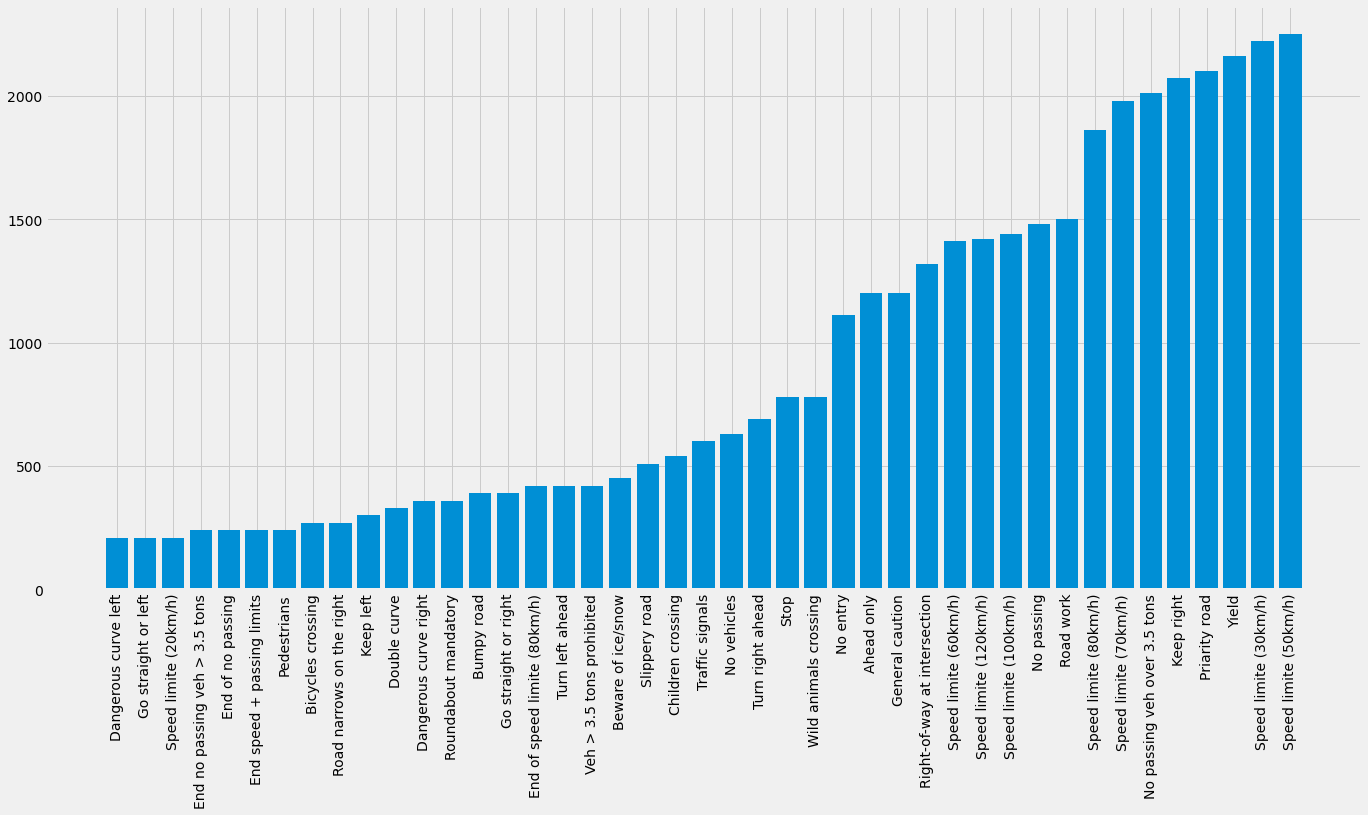

In [ ]:
folders = os.listdir(train_path)
train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

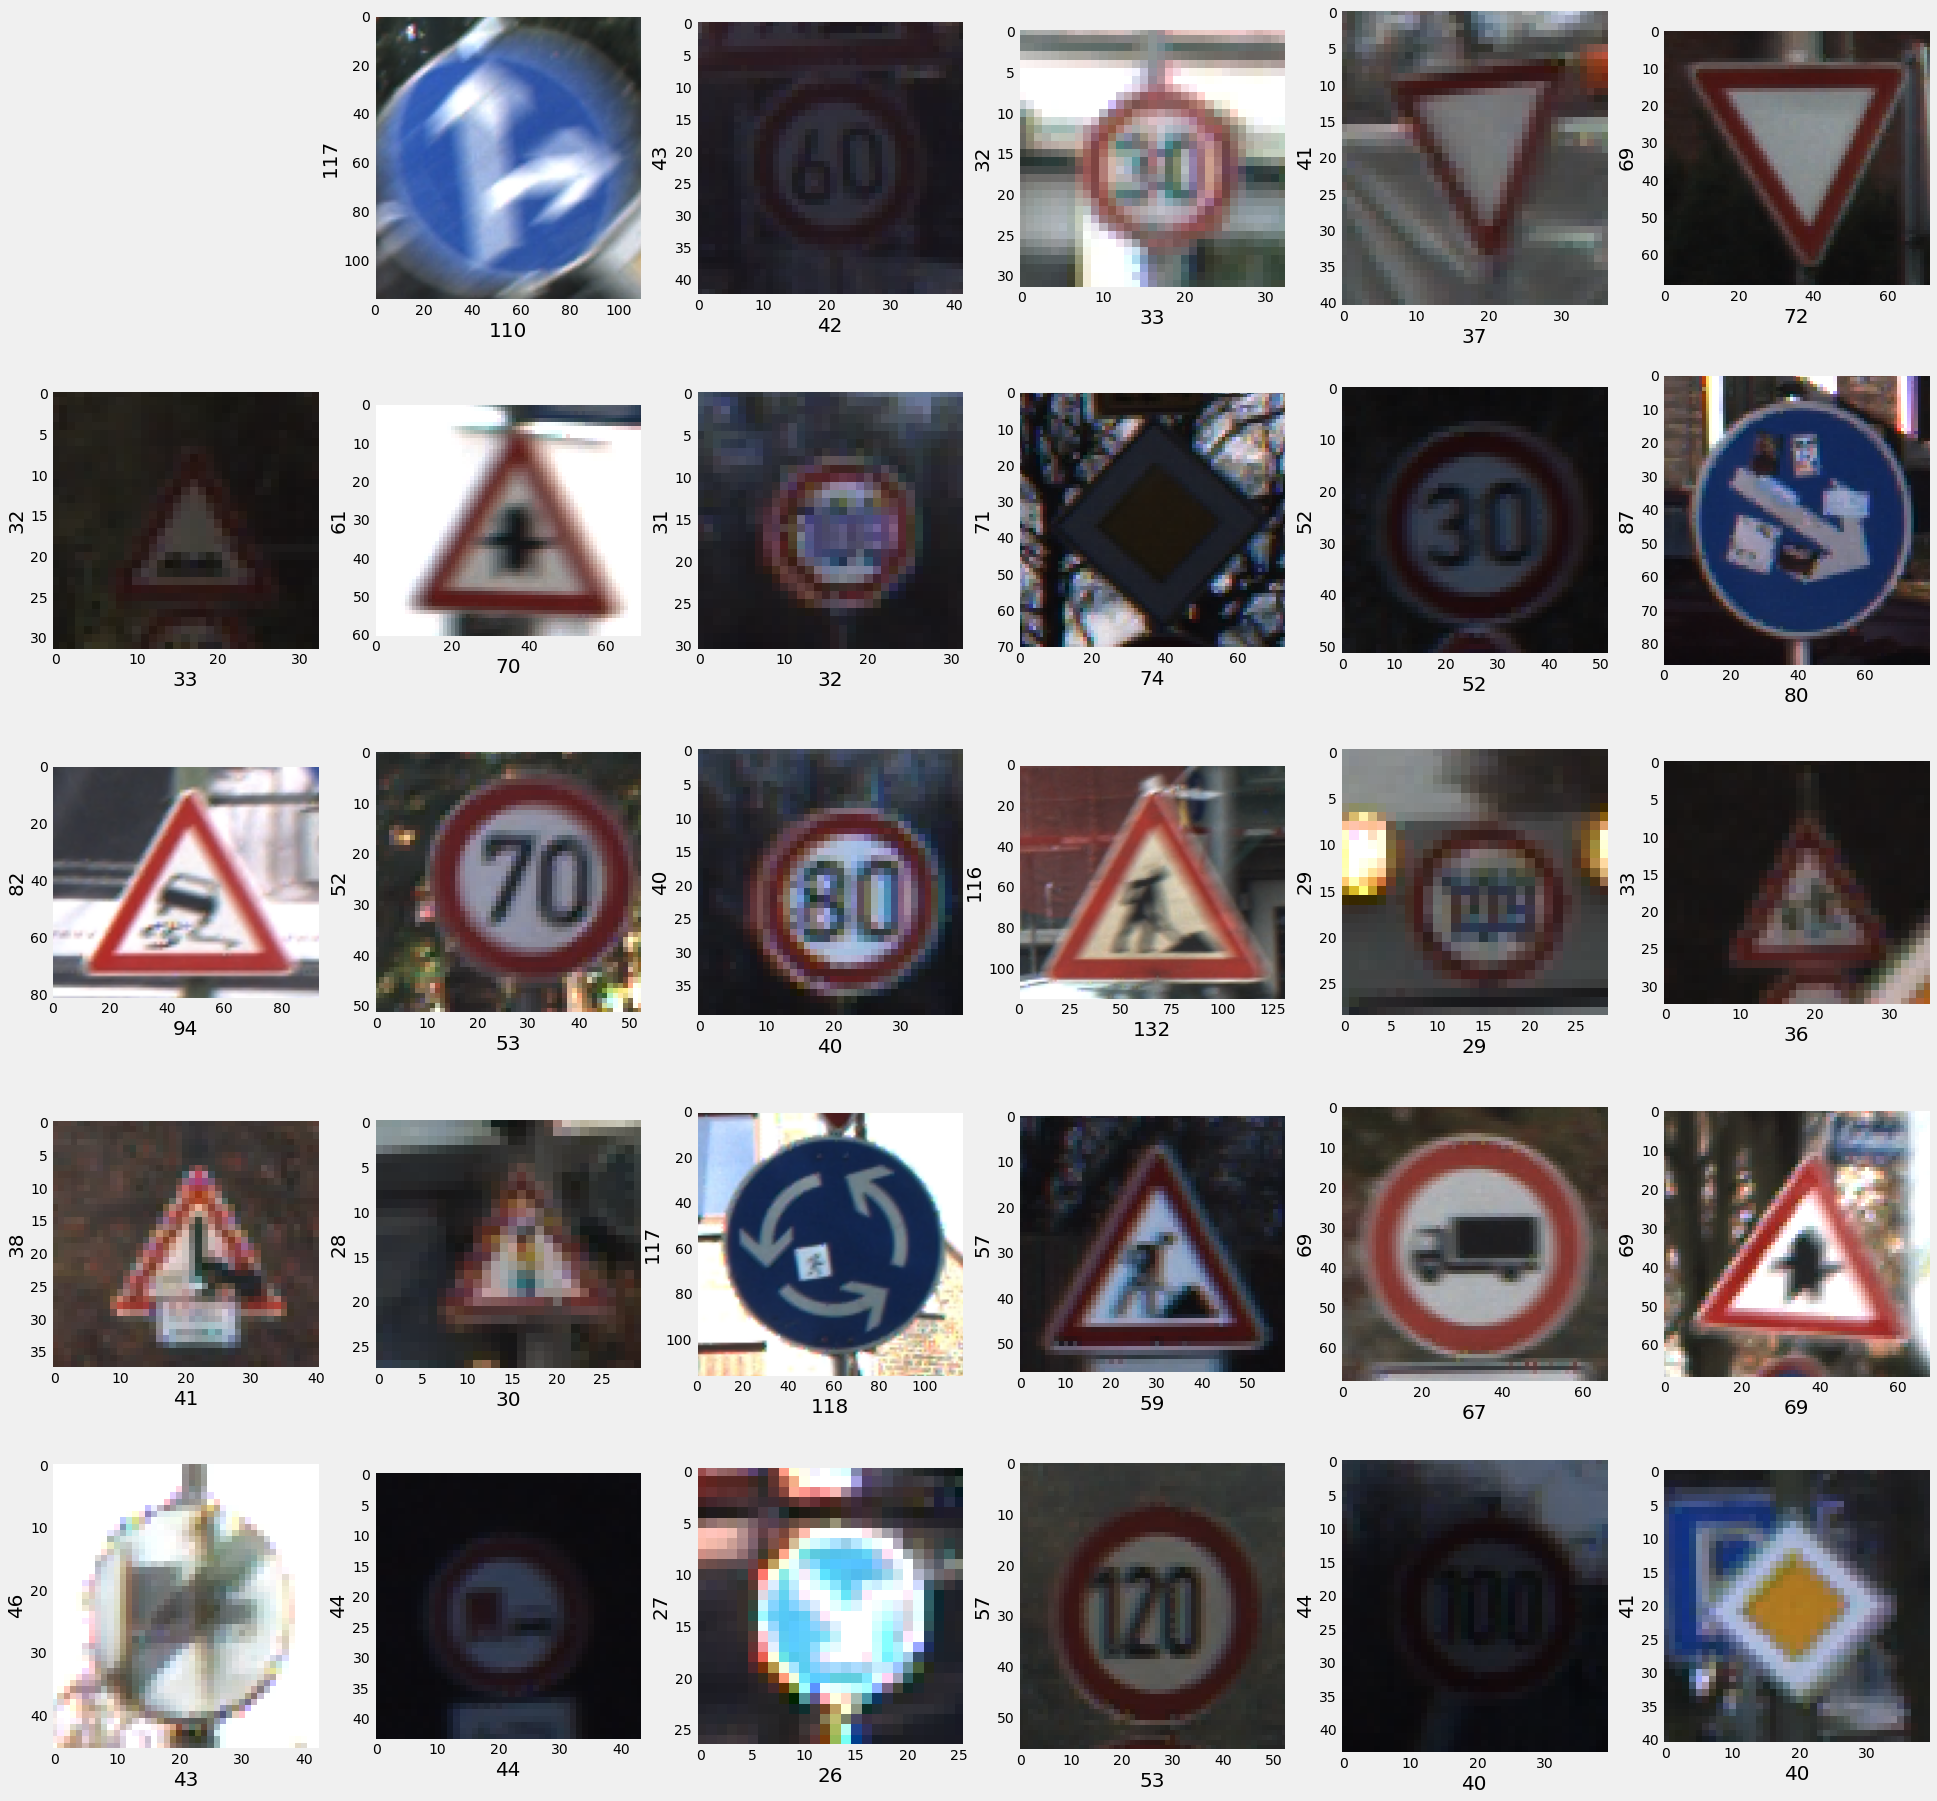

In [ ]:
test = pd.read_csv(my_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(30,30))

for i in range(1,30):
    plt.subplot(5,6,i + 1)
    random_img_path = my_dir + '/' + random.choice(imgs)
    random_img = imread(random_img_path)
    plt.imshow(random_img)
    plt.grid(b=None)
    plt.xlabel(random_img.shape[1], fontsize = 20)
    plt.ylabel(random_img.shape[0], fontsize = 20)


In [ ]:
image_data = []
image_labels = []
for i in range(num_categories):
    path = my_dir + '/Train/' + str(i)
    images = os.listdir(path)
    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((img_height, img_width))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error with " + img)
            
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39229, 30, 30, 3) (39229,)


In [ ]:
shuffle_index = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_index)
image_data = image_data[shuffle_index]
image_labels = image_labels[shuffle_index]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)
X_train = X_train/255 
X_val = X_val/255
print( X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

(27460, 30, 30, 3)
X_valid.shape (11769, 30, 30, 3)
y_train.shape (27460,)
y_valid.shape (11769,)


In [ ]:
y_train = keras.utils.to_categorical(y_train, num_categories)
y_val = keras.utils.to_categorical(y_val, num_categories)
print(y_train.shape)
print(y_val.shape)

(27460, 43)
(11769, 43)


In [ ]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(img_height,img_width,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [ ]:
lerning_rate = 0.001
epochs = 30
op = Adam(lr=lerning_rate, decay=lerning_rate / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
data_aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
history = model.fit(data_aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
859/859 [==============================] - 108s 124ms/step - loss: 1.1015 - accuracy: 0.7017 - val_loss: 0.0989 - val_accuracy: 0.9677
Epoch 2/30
859/859 [==============================] - 106s 123ms/step - loss: 0.1866 - accuracy: 0.9418 - val_loss: 0.1512 - val_accuracy: 0.9556
Epoch 3/30
859/859 [==============================] - 106s 123ms/step - loss: 0.1199 - accuracy: 0.9621 - val_loss: 0.0585 - val_accuracy: 0.9852
Epoch 4/30
859/859 [==============================] - 105s 123ms/step - loss: 0.0874 - accuracy: 0.9732 - val_loss: 0.0351 - val_accuracy: 0.9876
Epoch 5/30
859/859 [==============================] - 105s 122ms/step - loss: 0.0740 - accuracy: 0.9775 - val_loss: 0.0667 - val_accuracy: 0.9786
Epoch 6/30
859/859 [==============================] - 106s 123ms/step - loss: 0.0579 - accuracy: 0.9820 - val_loss: 0.0115 - val_accuracy: 0.9966
Epoch 7/30
859/859 [==============================] - 107s 125ms/step - loss: 0.0542 - accuracy: 0.9829 - val_loss: 0.0481 -

In [ ]:
model.save("model.h5")
model.save_weights("/content/drive/MyDrive/Colab Notebooks/Deep learning/trafic signe recognition/output/output")

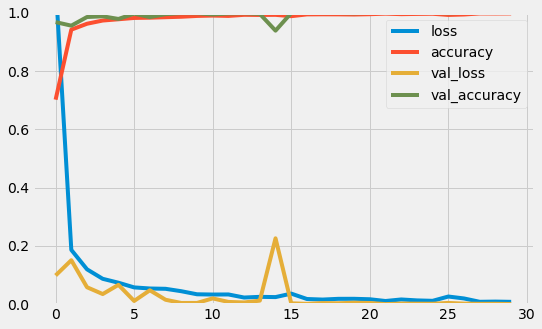

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
test = pd.read_csv(my_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]
for img in imgs:
    try:
        image = cv2.imread(my_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((img_height, img_width))
        data.append(np.array(resize_image))
    except:
        print("Error with " + img)
X_test = np.array(data)
X_test = X_test/255

predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

print('Test Data accuracy: ',accuracy_score(labels, classes_x)*100)

395/395 [==============================] - 11s 28ms/step
Test Data accuracy:  97.92557403008709


In [ ]:
print(classification_report(labels, classes_x))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.98      1.00      0.99       720
           2       0.99      0.99      0.99       750
           3       0.99      0.99      0.99       450
           4       1.00      0.98      0.99       660
           5       1.00      0.97      0.99       630
           6       1.00      1.00      1.00       150
           7       0.98      1.00      0.99       450
           8       0.99      1.00      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.97      0.93      0.95       420
          12       0.97      0.92      0.94       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.86      1.00      0.93       210
          16       0.99      1.00      1.00       150
          17       1.00    

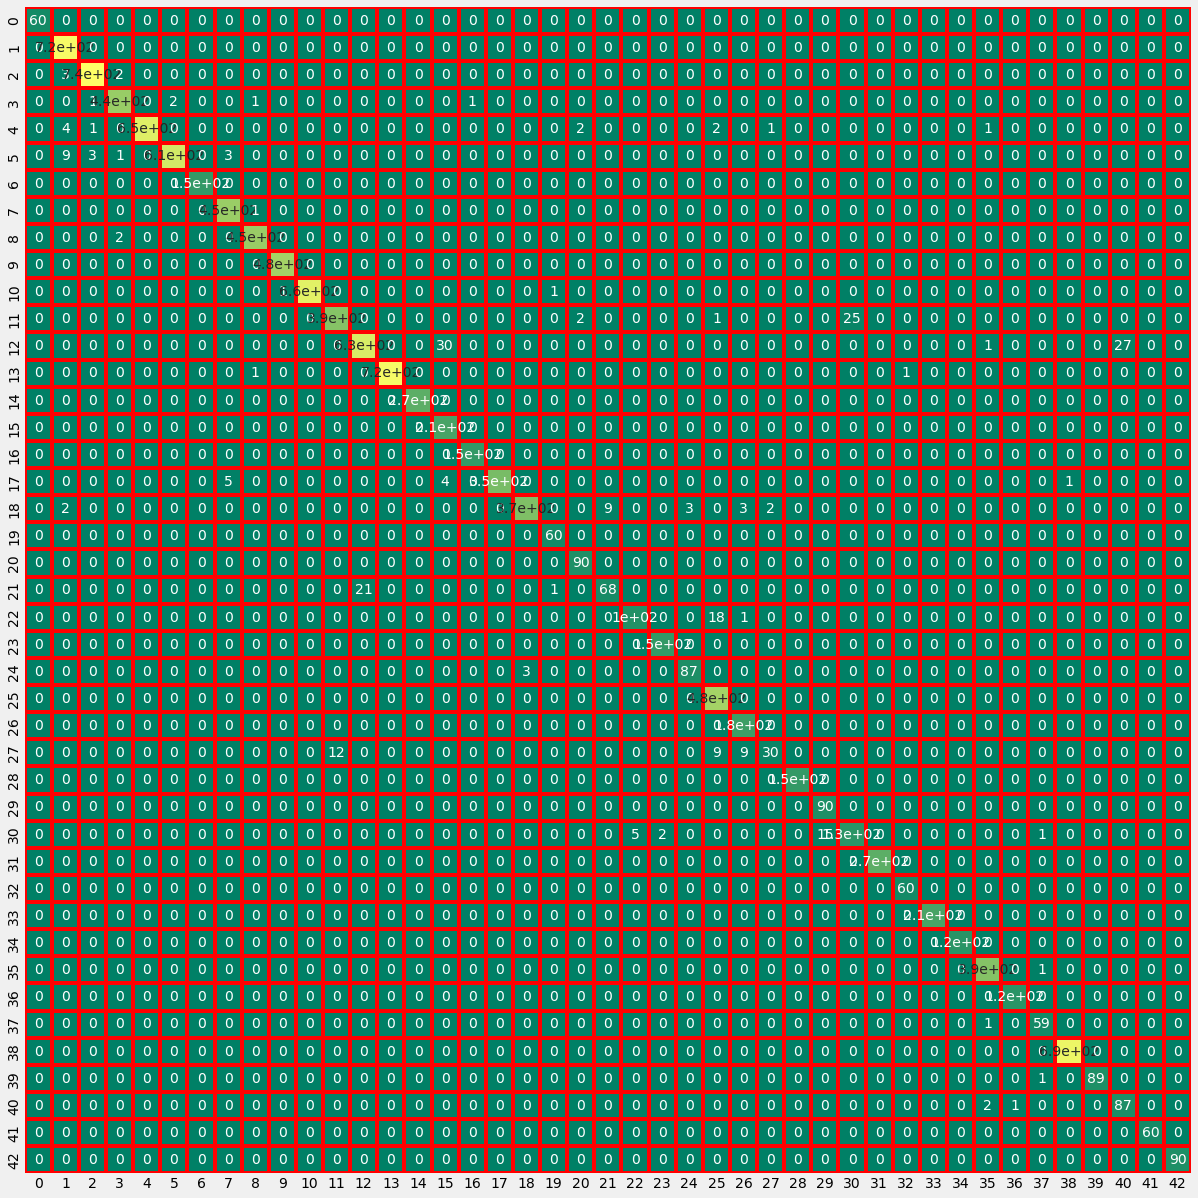

In [ ]:
cf = confusion_matrix(labels, classes_x)
df = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df, annot=True, cmap='summer', cbar=False, linewidths=3, linecolor='r', square=True)

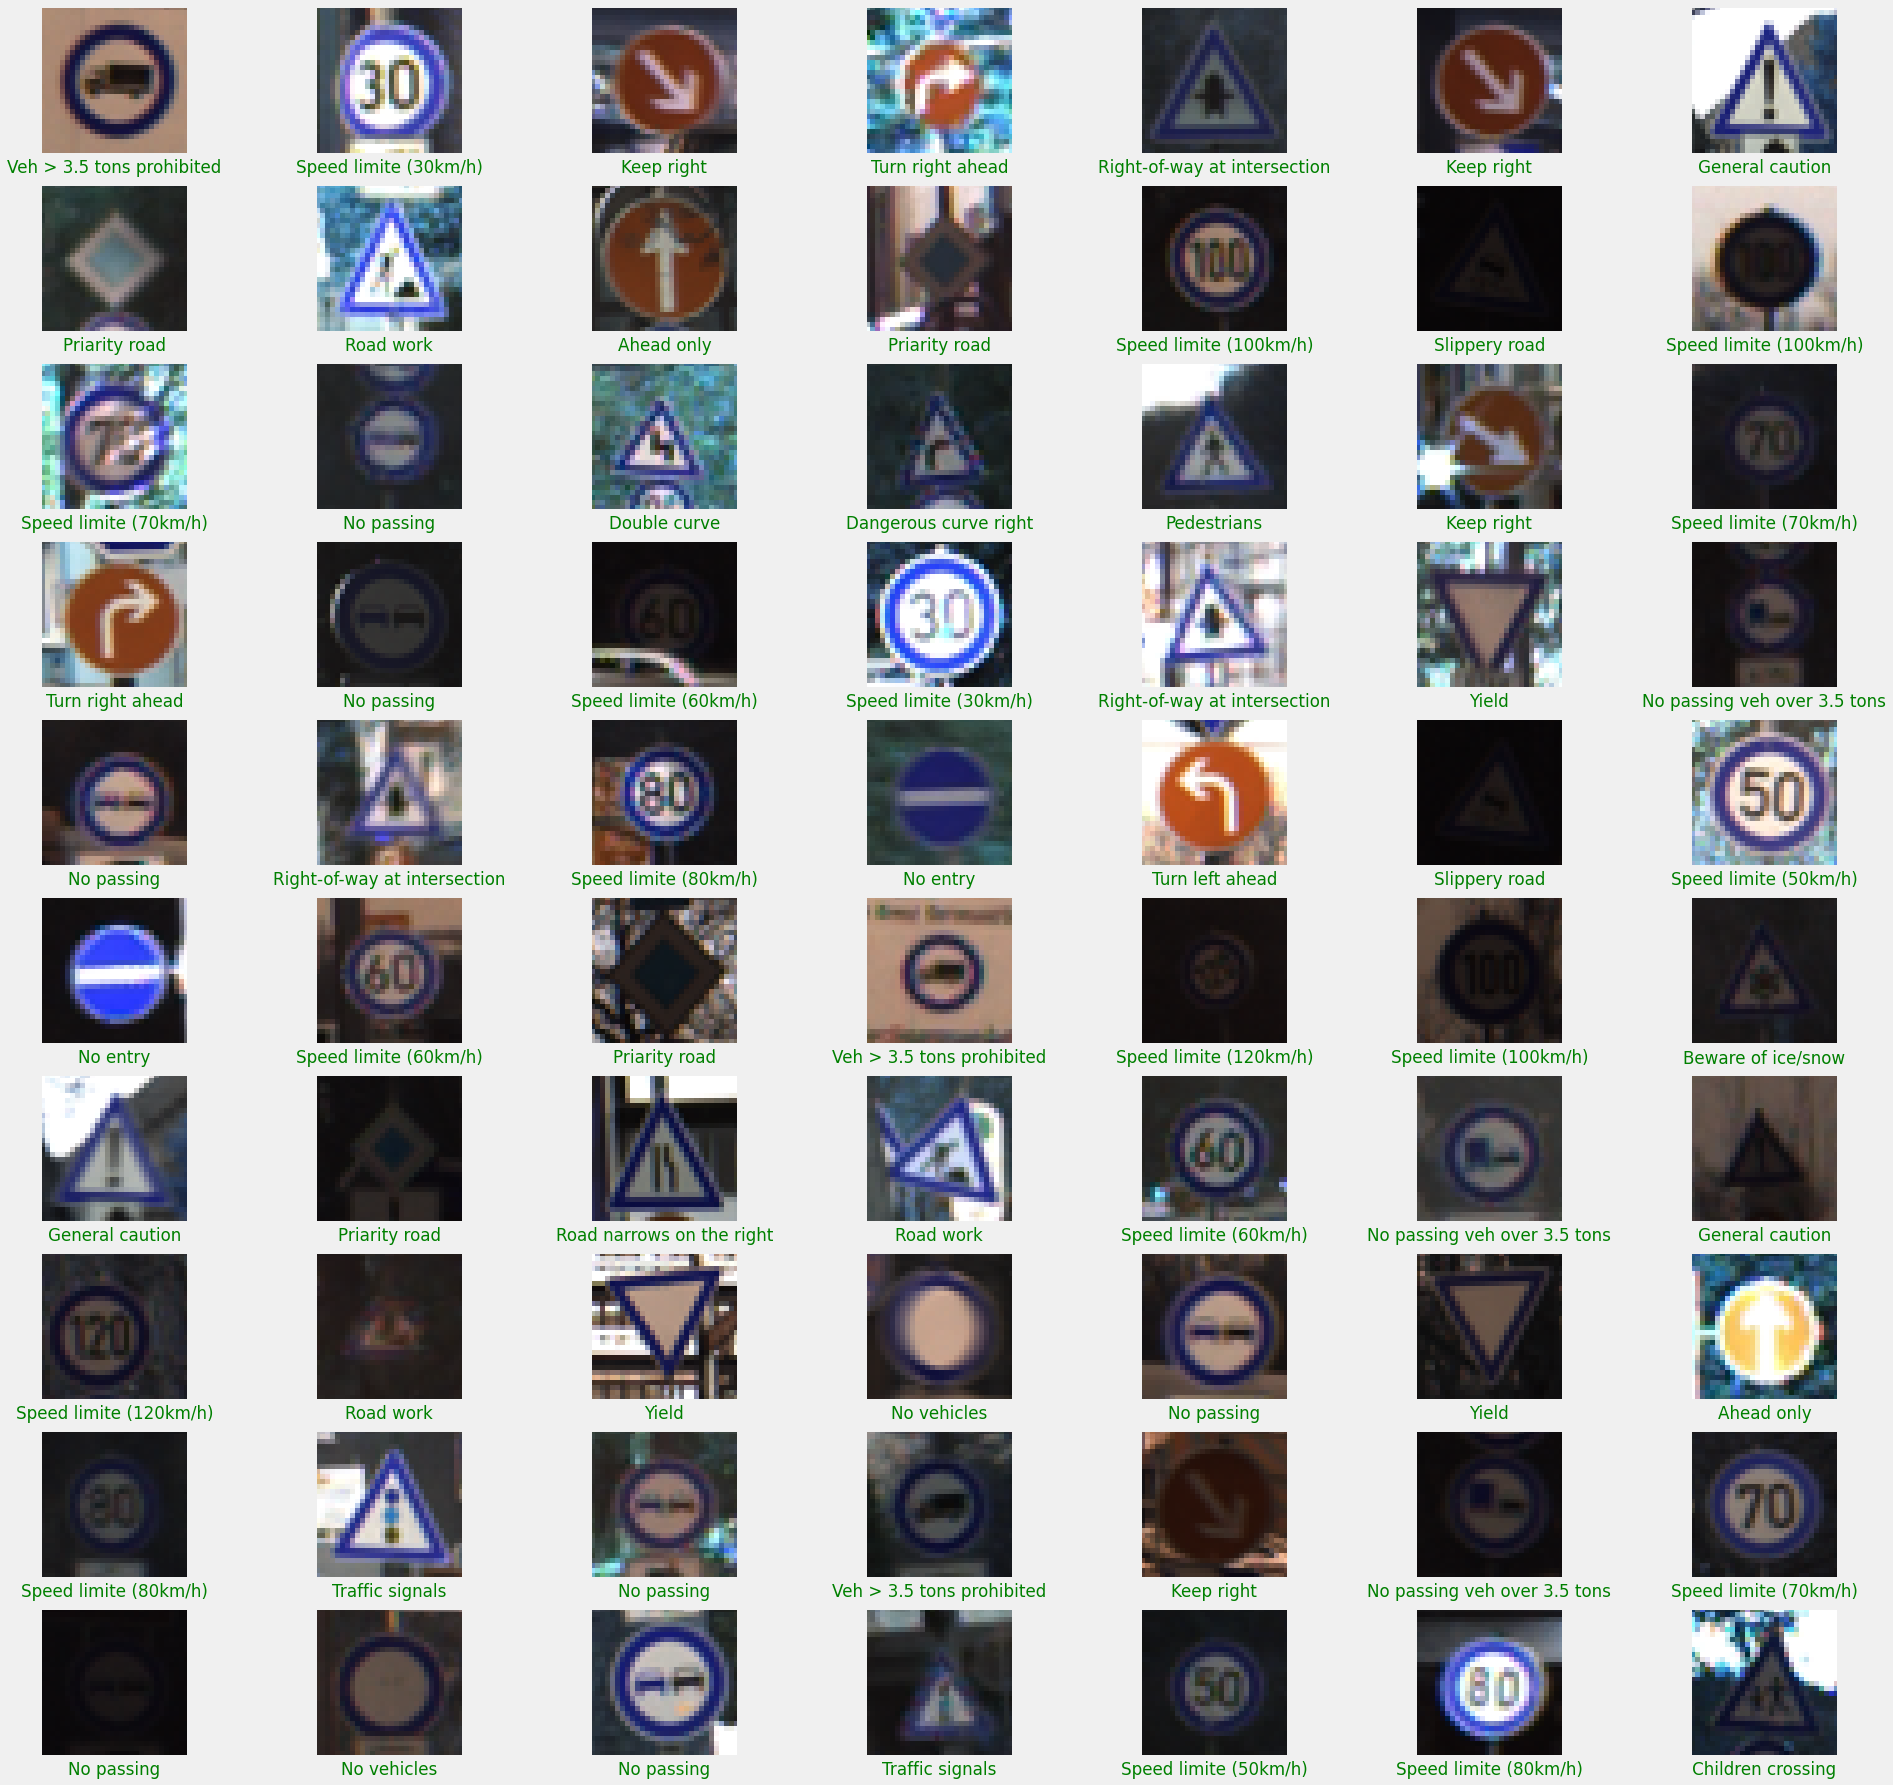

In [ ]:
plt.figure(figsize = (30, 30))
start_i = 0
for i in range(70):
    plt.subplot(10, 7, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    predict = classes_x[start_i + i]
    actual = labels[start_i + i]
    col = 'g'
    if predict != actual:
        col = 'r'
    plt.xlabel(format(classes[predict]), color = col)
    plt.imshow(X_test[start_i + i])
plt.show()